In [2]:
# import measurement as measurement
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(
    "sqlite:///hawaii.sqlite"
)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(
    engine,
    reflect=True
)

In [11]:
# View all of the classes that automap found
classes = Base.metadata.tables
columns = classes.values()
for clase in classes:
    print(clase + ":")
print(columns)



measurement:
station:
dict_values([Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)])


In [12]:
# Save references to each table
from sqlalchemy import Table, Column, INTEGER, MetaData, TEXT, FLOAT

measurement = Table('measurement', MetaData(),
                    Column(
                        'id',
                        INTEGER(),
                        primary_key=True,
                        nullable=False
                    ),
                    Column(
                        'station',
                        TEXT()
                    ),
                    Column(
                        'date',
                        TEXT()
                    ),
                    Column(
                        'prcp',
                        FLOAT()
                    ),
                    Column(
                        'tobs',
                        FLOAT()
                    ),
              schema=None)
station = Table('station', MetaData(),
                Column(
                    'id',
                    INTEGER(),
                    primary_key=True,
                    nullable=False
                ),
                Column(
                    'station',
                    TEXT()),
                Column(
                    'name',
                    TEXT()
                ),
                Column(
                    'latitude',
                    FLOAT()
                ),
                Column(
                    'longitude',
                    FLOAT()
                ),
                Column(
                    'elevation',
                    FLOAT()
                ),
          schema=None)

print(measurement.columns)
print(station.columns)

['measurement.id', 'measurement.station', 'measurement.date', 'measurement.prcp', 'measurement.tobs']
['station.id', 'station.station', 'station.name', 'station.latitude', 'station.longitude', 'station.elevation']


In [17]:
# Create our session (link) from Python to the DB

session = Session(engine)

print(session)

# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.

query = session.query(
    measurement
).order_by(
    measurement.columns.date
)

print(query[0])

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)


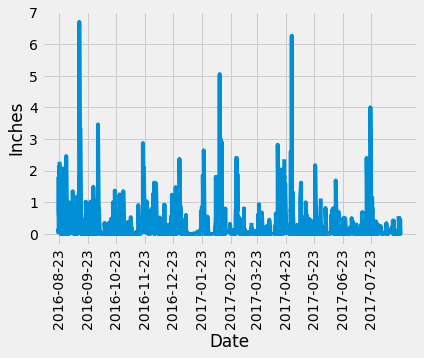

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

last = query[-1]

# Calculate the date one year from the last date in data set.

date = last[2]
date = str(int(date[:4]) - 1) + date[4:]

# Perform a query to retrieve the data and precipitation scores

precipitacionScores = session.query(
    measurement.columns.date,
    measurement.columns.prcp
).order_by(
    measurement.columns.date
).filter(
    measurement.columns.date >= date
)

# Save the query results as a Pandas DataFrame and set the index to the date column

ps = pd.read_sql(
    precipitacionScores.statement,
    precipitacionScores.session.bind
)

# Sort the dataframe by date

ps.sort_values(
    'date',
    ascending=False
)

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(ps['date'], ps['prcp'])
plt.ylabel("Inches")
plt.xlabel("Date")
diferents = []
months = []
for dte in ps.date:
    month = dte[5:7]
    day=dte[8:]
    if not month in months and day == '23':
        diferents.append(dte)
        months.append(month)
plt.xticks(diferents, rotation=90)
plt.show()


In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print("Precipitation statics:")
print(ps['prcp'].describe())

Precipitation statics:
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number stations in the dataset

totalStations = session.query(
    station.columns.station
).group_by(
    station.columns.station
)
print(totalStations.all())

[('USC00511918',), ('USC00513117',), ('USC00514830',), ('USC00516128',), ('USC00517948',), ('USC00518838',), ('USC00519281',), ('USC00519397',), ('USC00519523',)]


In [30]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

mainStations = session.query(
    measurement.columns.station,
    sqlalchemy.func.count(
        measurement.columns.station
    )
).group_by(
    measurement.columns.station
).order_by(
    sqlalchemy.desc(
        sqlalchemy.func.count(
            measurement.columns.station
        )
    )
)

# List the stations and the counts in descending order.

print(mainStations.all())

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

avg = session.query(
    sqlalchemy.func.avg(measurement.columns.tobs)
).filter(
    measurement.columns.station == mainStations.first()[0]
).scalar()

print(avg)

min = session.query(
    func.min(measurement.columns.tobs)
).filter(
    measurement.columns.station == mainStations.first()[0]
).scalar()

print(min)

max = session.query(
    func.max(measurement.columns.tobs)
).filter(
    measurement.columns.station == mainStations.first()[0]
).scalar()

print(max)


71.66378066378067
54.0
85.0


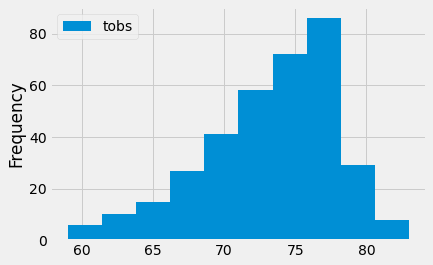

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(
    measurement.columns.date,
    measurement.columns.tobs
).filter(
    measurement.columns.date >= date,
    measurement.columns.station == mainStations.first()[0]
)

tempsDF = pd.read_sql(
    temps.statement,
    temps.session.bind
)

tempsDF.plot(kind='hist')

# Close session

In [33]:
# Close Session
session.close()